In [70]:
# Bibliotecas utilizadas para leitura e tratamento dos dados
import pandas as pd 
import pymysql 
import csv 
import numpy as np 
from itertools import combinations  

#Bibliotecas utilizads na estruturação do Grafo  
import networkx as nx
import dash
import dash_html_components as html
import dash_cytoscape as cyto
import matplotlib.pyplot as plt
import json 


import re 
import os 
from getpass import getpass

In [71]:
#Insira o usuário e senha do seu banco MySql local
user = "root" 
password = getpass() 

Obs: Certifique-se da existência do dataset "db_menu" no seu banco MySql local, caso contrário, execute o notebook "dumpScript.ipynb" antes da execução dos códigos abaixo.

## Load dos dados de MySql
A função "lodaData()" carrega uma tabela a partir do banco "db_menu". Essa função é usada para carregar os dados necessários para a construção dografoo.

In [72]:
def loadData(table): # get data from mysql database. 
    try: 
        conn = pymysql.connect(host = "localhost", 
                      user = user, 
                      password = password, 
                      db = "db_menu") 
        query = "SELECT * FROM {}".format(table) 

        df = pd.read_sql(query, conn) 

        return df 
            
            
    except: 
        conn.close()         

In [73]:
dish = loadData("dish") 
dish.head() 

,id,name,description
0,21,English walnuts,None
1,50,Cracked Wheat,None
2,286,Scrambled Eggs,None
3,393,Blue Point Stew,None
4,460,Passion Fruit,None


In [74]:
menu_item= loadData("menu_item") 
menu_item.head() 

,id,menu_page_id,dish_id,price
0,1,1389,21,0.25
1,2,130,50,NaN
2,3,13915,50,NaN
3,4,5946,286,NaN
4,5,4857,286,NaN


In [75]:
menu = loadData("menu") 
menu.head() 

,id,name,event_date,event_id,sponsor_id,currency_id,venue_id
0,12463,None,1900-04-15,1,1,1,1
1,12465,None,1900-04-16,2,2,1,1
2,12466,None,1900-04-16,3,2,1,1
3,12470,None,1900-04-17,2,2,1,1
4,12475,None,1900-04-18,4,3,2,1


In [76]:
menu_page = loadData("menu_page") 
menu_page.head() 

,id,page_number,full_height,full_width,menu_id
0,130,1.0,3049,2004,12463
1,134,1.0,3411,2291,12465
2,136,1.0,3365,2305,12466
3,146,1.0,3427,2282,12470
4,168,1.0,3929,2494,12475


# Cálculos 

Doravante, serão feitos os cálculos para os nós, representados pelos pratos, e as arestas, indicativas da coexistência de refeições em um menu, dos grafos. Para isso, calcularemos, para cada par de pratos, em quantos menus eles aparecem juntos.  

Inicialmente, realizamos as necessárias junções nos conjuntos de dados para obter uma tabela razoável para construir um grafo. 

In [77]:
dish_page = pd.merge(dish, menu_item, left_on = "id", right_on = "dish_id")
#dish_page.head() 
menu_item.head()

,id,menu_page_id,dish_id,price
0,1,1389,21,0.25
1,2,130,50,NaN
2,3,13915,50,NaN
3,4,5946,286,NaN
4,5,4857,286,NaN


In [78]:
dish_page_menu = pd.merge(dish_page, menu_page, left_on = "menu_page_id", right_on = "id")
dish_page_menu = dish_page_menu[["name", "dish_id", "menu_page_id", "menu_id"]] 
dish_page_menu.head() 

,name,dish_id,menu_page_id,menu_id
0,English walnuts,21,1389,12882
1,English walnuts,21,3531,13619
2,"Omelet, plain",2001,3531,13619
3,English walnuts,21,4128,13810
4,English walnuts,21,4377,13900


In [79]:
dish_menu = pd.merge(dish_page_menu, menu, left_on = "menu_id", right_on = "id") 
dish_menu = dish_menu[["name_x", "dish_id", "menu_id", "event_date", "event_id", "sponsor_id"]] 
df = dish_menu.rename(columns = {"name_x": "name"}) 
df.head() 

,name,dish_id,menu_id,event_date,event_id,sponsor_id
0,English walnuts,21,12882,1900-04-09,22,56
1,English walnuts,21,13619,1901-04-26,22,159
2,"Omelet, plain",2001,13619,1901-04-26,22,159
3,Old Jamaica Rum,1353,13619,1901-04-26,22,159
4,SCOTCH WHISKEY,2818,13619,1901-04-26,22,159


In [44]:
# execute a célula seguinte, que contém os scripts sql! 
dish_names = df.name.unique() 

nodes = [] 
count = 0 
for combination in combinations(dish_names, 2): 
    print(count, end = "\r") 
    df_l = df[df["name"] == combination[0]] 
    df_r = df[df["name"] == combination[1]] 
    
    df_lr = pd.merge(df_l, df_r, on = "menu_id") 
    
    x = len(df_lr) 
    
    count = count + 1 
    nodes.append({
        "dish_l": combination[0], 
        "dish_r": combination[1], 
        "count": x 
    })


Alternativamente, podemos fazer consultas em SQL. 

In [45]:
conn = pymysql.connect(host = "localhost", 
              user = user, 
              password = password, 
              db = "db_menu") 
cur = conn.cursor() 

In [46]:
def get_df(year = None, conn = conn): 
    query_a = """ 
    SELECT dm.dish_id, dm.name, dm.menu_id, menu.event_date, menu.venue_id,   
           dm.menu_page_id FROM menu 
        JOIN (SELECT dish_id, name, menu_page_id, id, menu_id FROM menu_page 
                JOIN (SELECT dish_id, name, menu_page_id FROM dish
                        JOIN menu_item 
                        ON dish.id = menu_item.dish_id) as ds
                ON menu_page.id = ds.menu_page_id) as dm
        ON menu.id = dm.menu_id""" 

    query_b = """SELECT x.dish_id AS dish_id_x, y.dish_id AS dish_id_y, 
                 LOWER(x.name) AS name_x, LOWER(y.name) AS name_y, x.event_date, 
                 x.venue_id, x.menu_page_id, 
                 x.menu_id AS menu_id_x, y.menu_id AS menu_id_y 
                 FROM ({query}) AS x 
                 INNER JOIN ({query}) AS y 
                 ON x.menu_id = y.menu_id 
                 AND x.dish_id < y.dish_id""".format(query = query_a) 

    # filter year 

    if year is not None: 
        query_year = """SELECT * FROM ({query}) as a
                         WHERE YEAR(a.event_date) = {year}""".format(query = query_b, 
                                                                    year = year) 
    else: 
        query_year = query_b 

    query_c = """SELECT a.name_x, a.name_y, COUNT(a.name_x) as count  
                    FROM ({query}) as a                    
                    WHERE a.name_x NOT LIKE '%[^a-z]%' 
                    GROUP BY a.name_x, a.name_y 
                    ORDER BY count DESC""".format(query = query_year) 
    df = pd.read_sql(query_c, conn) 
    return df 

In [47]:
def save_file(table, name = "table"): 
    try: 
        os.mkdir("./data_csv") 
    except: 
        directory = "./data_csv/" 
    
    csv = table.to_csv(index = False, encoding = "utf-8") # encoding!  
    
    with open(directory + name + ".csv", "w") as file: 
        file.write(csv)     

In [48]:
save_file(get_df()) 

In [49]:
df["year"] = list(map(lambda x: int(x[:4]) if x is not None else x, df["event_date"].tolist()))  
years = df.year.unique() 

In [50]:
def dishs_year(conn = conn): 
    query_a = """ 
SELECT dm.dish_id, dm.name, dm.menu_id, menu.event_date, menu.venue_id,   
       dm.menu_page_id FROM menu 
    JOIN (SELECT dish_id, name, menu_page_id, id, menu_id FROM menu_page 
            JOIN (SELECT dish_id, name, menu_page_id FROM dish
                    JOIN menu_item 
                    ON dish.id = menu_item.dish_id) as ds
            ON menu_page.id = ds.menu_page_id) as dm
    ON menu.id = dm.menu_id""" 

    query_b = """SELECT x.dish_id AS dish_id_x, y.dish_id AS dish_id_y, 
                 LOWER(x.name) AS name_x, LOWER(y.name) AS name_y, YEAR(x.event_date) AS year, 
                 x.venue_id, x.menu_page_id, 
                 x.menu_id AS menu_id_x, y.menu_id AS menu_id_y 
                 FROM ({query}) AS x 
                 INNER JOIN ({query}) AS y 
                 ON x.menu_id = y.menu_id 
                 AND x.dish_id < y.dish_id""".format(query = query_a) 
    
    query_c = """SELECT a.name_x, a.year, COUNT(a.dish_id_x) as count 
                    FROM ({query}) AS a 
                    GROUP BY a.year, a.dish_id_x""".format(query = query_b) 
    return pd.read_sql(query_c, conn) 

dishs_year().head() 

,name_x,year,count
0,scrambled eggs,1900.0,145
1,congress water,1900.0,185
2,salad-beetroot,1900.0,1
3,french mustard,1865.0,3
4,"schreider, dry",1865.0,1


Após o tratamento dos dados, faz-se necessário salva-los em um arquivo csv para utiliza-los posteriormente na aplicação do Grafo.

In [51]:
save_file(dishs_year(), name = "scatter_data")  

In [52]:
try: 
    for year in years: 
        nodes_year = get_df(year, conn) 
        save_file(nodes_year, name = "nodes_year_" + str(year))     
except Exception as e: 
    print("nan") 

nan


# NetworkX

Para o que falta, vamos utilizar o Dash Cytoscape para construir a visualização. 

In [53]:
#Separando os dados
df = get_df() 
np.random.seed(11) 
names_dish = df.name_x.unique() 
print(names_dish)
sample = np.random.choice(len(names_dish), 125) 
names = names_dish[sample] 

['scrambled eggs' 'apple tartlets' 'prunelle brandy' 'cracked wheat'
 'congress water' 'salt mackerel' 'hamburg chicken' 'bromo seltzer'
 'cold consomme' 'roast chicken' 'stuffed tomato' 'buttered toast'
 'omelet, plain' 'blackberry pie' 'gin, plymouth' 'deviled crabs'
 'potage lamballe' 'half cantaloupe' 'stewed rhubarb' 'salad, chicken'
 'scotch whiskey' 'milk crackers' 'schweizer käse' 'jus de tomate'
 'fortune cakes' 'salted pecans' 'florida orange' 'small beefsteak'
 'codfish balls' 'english walnuts' 'fried haddock' 'chicken halibut'
 'consommé chaud' 'stuffed olives' 'italian salad' 'maryland club'
 'figs, in syrup' 'old jamaica rum' 'prunes, stewed' 'peach ice cream'
 'early june peas' 'cream of wheat' 'almond chicken' 'hennessy 3 star'
 'the de ceylan' 'coffee parfait' 'sea tag oysters' 'tomato sandwich'
 'broiled salmon' 'chicken, half' 'corn on the cob' 'stuffed prunes'
 'egg, duvivier' 'bamboo cocktail' 'english stilton' 'french crullers'
 'chablis, white' 'virginia bacon' '

In [54]:
df = df[df["name_x"].isin(names)] 

In [55]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 1 to 1754
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name_x  408 non-null    object
 1   name_y  408 non-null    object
 2   count   408 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 12.8+ KB


In [56]:
df.name_x.value_counts() 

stuffed tomato     45
salad, chicken     34
broiled salmon     29
italian salad      26
stewed rhubarb     22
                   ..
sauternes, 1905     1
narbonne honey      1
schreider, dry      1
bohemia (ale)       1
beef, per cut       1
Name: name_x, Length: 101, dtype: int64

In [57]:
G = nx.Graph() 

## Add nodes

Adicionando nós a instância nx.Graph() com o atributo "color = lightblue" referente a todos os tipos de entidade.

In [58]:
for name in names: 
    G.add_node(name, 
              color = "lightblue") 

## Add edge

Adicionando as arestas do Grafo, especificando o nó de origem e destino da "conexão". Cada aresta possui o atributo "weight" utilizado para definir a espessura de cada de linha de conexão.

In [59]:
for index in range(len(df.index)): 
    G.add_edge(
        df["name_x"].tolist()[index], 
        df["name_y"].tolist()[index], 
        weight = df["count"].tolist()[index] 
    )
G.size(weight = "frequency") 

408.0

A partir da instância nx.Graph(), com seus devidos atributos, a função nx.draw_netwroks gera o grafo com o auxílio do matplotlib.

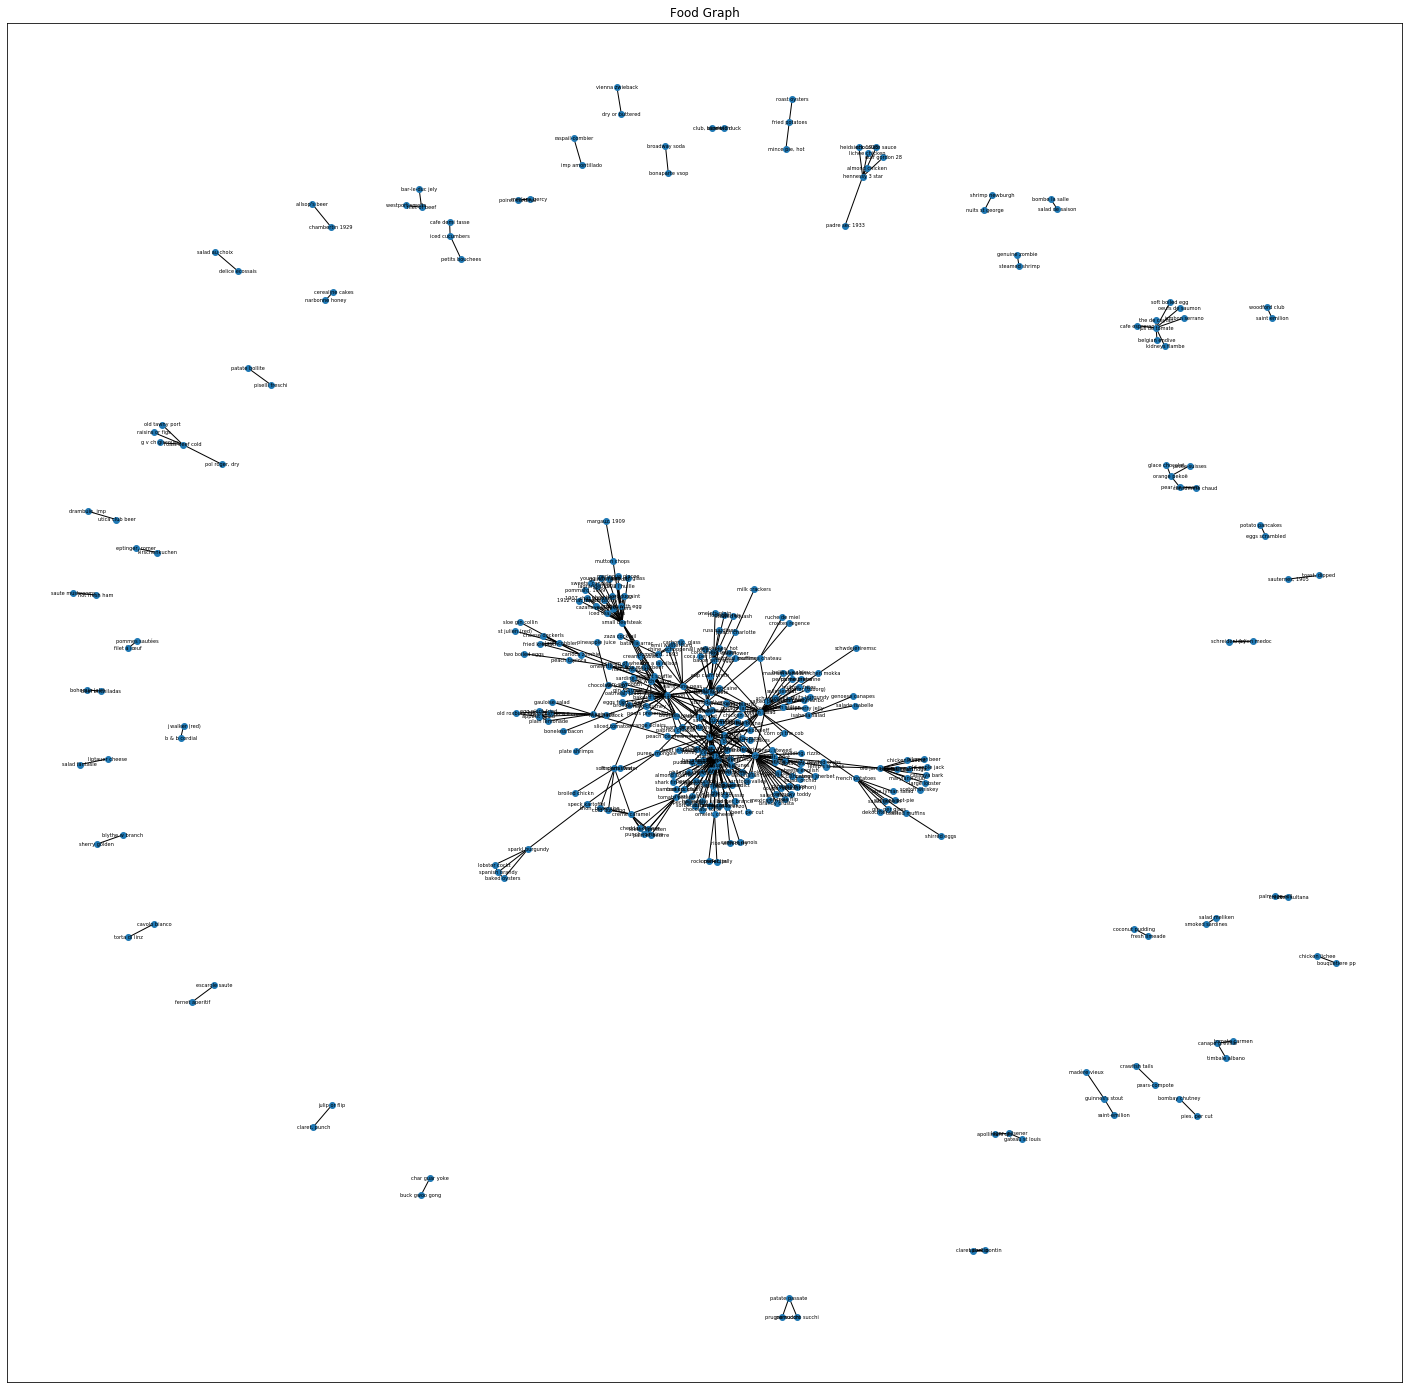

In [60]:
pos = nx.spring_layout(G, scale=.5)
fig, ax = plt.subplots(figsize=(25,25))
ax.set_title("Food Graph")
nx.draw_networkx(G, pos = pos, node_size = 35, font_size = 5)  